In [ ]:
!unzip qvit_code_3.zip

Archive:  qvit_code_3.zip
replace __MACOSX/._qvit_code_3? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install tensorcircuit
!pip install pennylane
!pip install -U qiskit
!pip install -U cirq

ERROR: Operation cancelled by user


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import math
from tqdm.notebook import tqdm
import time
from torchvision.datasets import MNIST
from torchvision import transforms
import h5py
import sys
sys.path.append('/content/qvit_code')
from QViT import *
#from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix

torch.set_default_dtype(torch.float32)
torch.set_num_threads(8)
device='cpu' # technically algorithm can be run on cpu but for speed reasons, it is not suggested.

## Models

In [ ]:
mnist_trainset = MNIST(root='./data', train=True, download=True)
n,d= 7,28

transform = transforms.Compose([ transforms.Resize((14,14)), transforms.ConvertImageDtype(torch.float64),transforms.Normalize(0,1)])
data = mnist_trainset.data  # size = (60000, 28, 28_)
data = transform(data)      # size = (60000, 14, 14)
data_patched = patcher(data,[2,14])

mnist_trainset = simple_dataset(data_patched,mnist_trainset.targets)
tr_len = 4000
val_len = 1000
tr_set,val_set,test_set = torch.utils.data.random_split(mnist_trainset,[tr_len,val_len,mnist_trainset.target.shape[0]-tr_len-val_len])
tr_dl = DataLoader(tr_set,batch_size=32,shuffle=True)
val_dl = DataLoader(val_set,batch_size=32,shuffle=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.80MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 154kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.23MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# I changed these hyper parameters a little bit for the original parameters refer elsewhere

In [ ]:
# transformer_dims = {'Token_Dim':data_patched.shape[-2],
#                     'Image_Dim':data_patched.shape[-1]}
# transformer_hyper = {'n_layers':2,'FC_layers':[10],
#                     'head_dimension':8,'Embed_Dim': 16,
#                      'ff_dim':32}
# transformer_type = {'classifying_type':'max','pos_embedding':True}

transformer_dims = {
    'Token_Dim': data_patched.shape[-2],  # Keep this as is
    'Image_Dim': data_patched.shape[-1]   # Keep this as is
}

transformer_hyper = {
    'n_layers': 2,
    'FC_layers': [64, 32],
    'head_dimension': 4,
    'Embed_Dim': 32,
    'ff_dim': 64
}

transformer_type = {
    'classifying_type': 'max',
    'pos_embedding': True
}

## Initialization

In [ ]:
# initialized models
classical_model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='classic').to(device)
hybrid2_model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='hybrid2').to(device)

Quantum Circuit for V layer:
     ┌───┐┌───────┐┌───────┐┌───────┐                                     »
q_0: ┤ H ├┤ Rx(0) ├┤ Rx(0) ├┤ Ry(0) ├──■──────────────────────────────────»
     ├───┤├───────┤├───────┤├───────┤┌─┴─┐     ┌───────┐                  »
q_1: ┤ H ├┤ Rx(0) ├┤ Rx(0) ├┤ Ry(0) ├┤ X ├──■──┤ Ry(0) ├──────────────────»
     ├───┤├───────┤├───────┤├───────┤└───┘┌─┴─┐└───────┘┌───────┐         »
q_2: ┤ H ├┤ Rx(0) ├┤ Rx(0) ├┤ Ry(0) ├─────┤ X ├────■────┤ Ry(0) ├─────────»
     ├───┤├───────┤├───────┤├───────┤     └───┘  ┌─┴─┐  └───────┘┌───────┐»
q_3: ┤ H ├┤ Rx(0) ├┤ Rx(0) ├┤ Ry(0) ├────────────┤ X ├──────■────┤ Ry(0) ├»
     ├───┤├───────┤├───────┤├───────┤            └───┘    ┌─┴─┐  └───────┘»
q_4: ┤ H ├┤ Rx(0) ├┤ Rx(0) ├┤ Ry(0) ├─────────────────────┤ X ├──────■────»
     ├───┤├───────┤├───────┤├───────┤                     └───┘    ┌─┴─┐  »
q_5: ┤ H ├┤ Rx(0) ├┤ Rx(0) ├┤ Ry(0) ├──────────────────────────────┤ X ├──»
     ├───┤├───────┤├───────┤├───────┤                      

# set reset_classical and reset_hybrid2 to true after the Training section is done and after the files are created
# DO NOT run training if this is set to false and the training data already exists!!!

In [ ]:
# history
reset_classical=True
reset_hybrid2=True

if reset_classical:
    classical_history=None
else:
    classical_history=torch.load('/content/qvit_code/classical history')
    classical_model.load_state_dict(torch.load('/content/qvit_code/classical state dict'))

if reset_hybrid2:
    hybrid2_history=None
else:
    hybrid2_history=torch.load('/content/qvit_code/hybrid2 history')
    hybrid2_model.load_state_dict(torch.load('/content/qvit_code/hybrid2 state dict'))

## Training

In [ ]:
classical_optim = torch.optim.Adam(classical_model.parameters(),lr=1e-3)
hybrid2_optim = torch.optim.Adam(hybrid2_model.parameters(),lr=1e-3)
n_epochs = 80
loss_fn = nn.CrossEntropyLoss(reduction='none')

In [ ]:
# classical training
classical_history = train(classical_model,tr_dl,val_dl,loss_fn,classical_optim,n_epochs,
                          history=classical_history,save_path="classical state dict",device=device)
torch.save(classical_history, "classical history")

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
# hybrid2 training
hybrid2_history = train(hybrid2_model,tr_dl,val_dl,loss_fn,hybrid2_optim,n_epochs,
                        history=hybrid2_history,save_path='hybrid2 state dict',device=device)
torch.save(hybrid2_history, 'hybrid2 history')

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

## Plotting

"\nplt.figure()\nplt.imshow(confusion_matrix(pred.cpu(),test_set.dataset.target[test_set.indices[:1000]],normalize='true'),\n          vmin=0,vmax=1)\nplt.colorbar()\nplt.title('The normalized confusion matrix')\nprint(f'Wrongly Predicted Ratio:{ (pred != test_set.dataset.target[test_set.indices[:1000]]).sum()/pred.shape[0]}')\n"

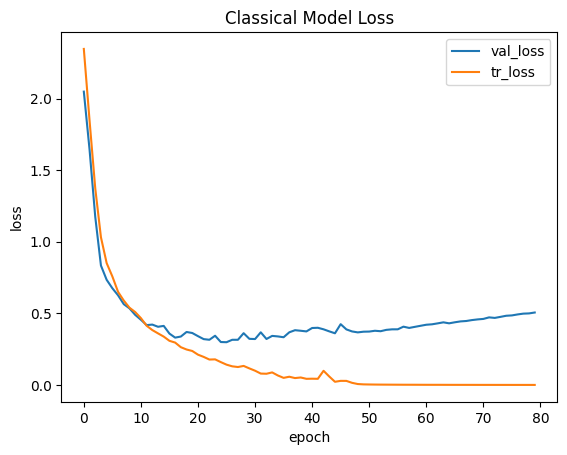

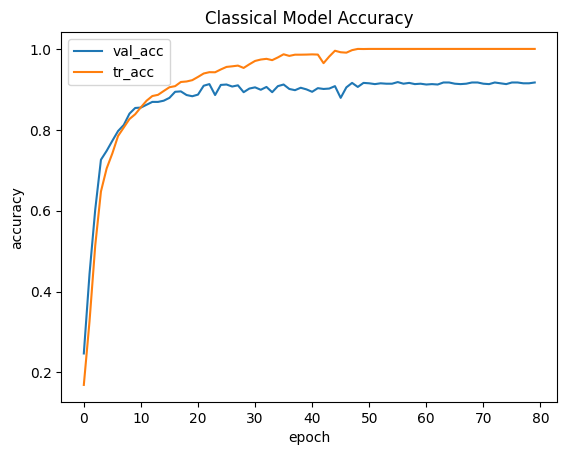

In [ ]:
#model(data_patched[[0]].to(device))
#print(f'# of parameters: {sum([np.prod(i.shape) for i in model.parameters()])}')
#model.load_state_dict(torch.load('best_state_on_training_acc'))

plt.plot(classical_history['val'],label='val_loss')
plt.plot(classical_history['tr'],label='tr_loss')
plt.title('Classical Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.figure()
plt.plot(classical_history['val_acc'],label='val_acc')
plt.plot(classical_history['tr_acc'],label='tr_acc')
plt.title('Classical Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

#pred = model(test_set.dataset.data[test_set.indices[:1000]].to(device)).cpu().argmax(axis=1)
"""
plt.figure()
plt.imshow(confusion_matrix(pred.cpu(),test_set.dataset.target[test_set.indices[:1000]],normalize='true'),
          vmin=0,vmax=1)
plt.colorbar()
plt.title('The normalized confusion matrix')
print(f'Wrongly Predicted Ratio:{ (pred != test_set.dataset.target[test_set.indices[:1000]]).sum()/pred.shape[0]}')
"""

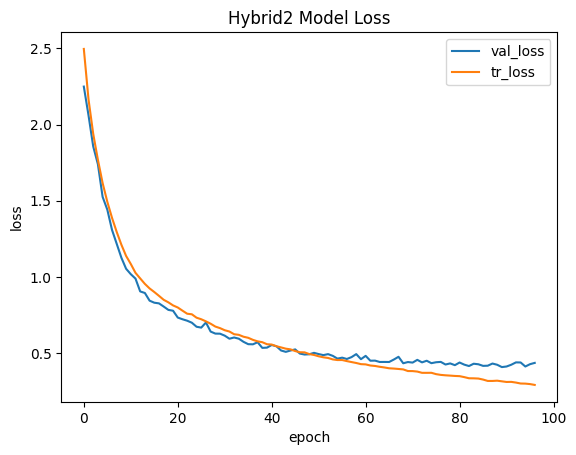

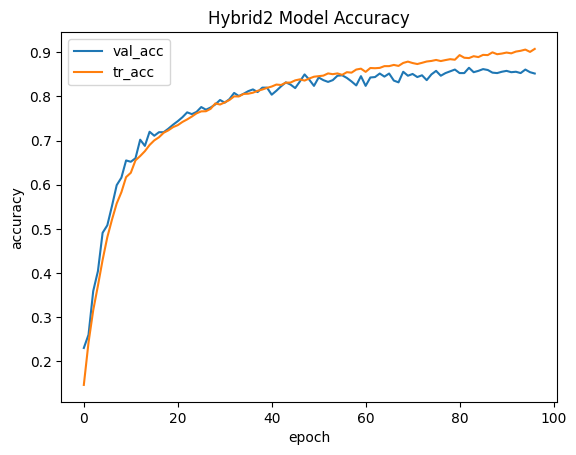

In [ ]:
plt.plot(hybrid2_history['val'],label='val_loss')
plt.plot(hybrid2_history['tr'],label='tr_loss')
plt.title('Hybrid2 Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.figure()
plt.plot(hybrid2_history['val_acc'],label='val_acc')
plt.plot(hybrid2_history['tr_acc'],label='tr_acc')
plt.title('Hybrid2 Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

## Proof of concept

In [ ]:
data[0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0196, 0.0588, 0.1176, 0.1686, 0.3020,
         0.2706, 0.3961, 0.3137, 0.0275, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0941, 0.4824, 0.6706, 0.8039, 0.8588, 0.8706,
         0.5412, 0.5333, 0.3020, 0.0196, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0902, 0.5725, 0.8157, 0.8588, 0.4824, 0.5255,
         0.1255, 0.0314, 0.0118, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0039, 0.0588, 0.3608, 0.6745, 0.0980, 0.0353,
         0.0078, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0902, 0.5725, 0.4863, 0.1765,
         0.0118, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.1608, 0.6078, 0.7059,
  

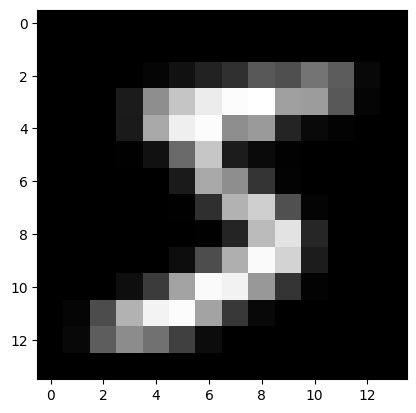

In [ ]:
plt.imshow(data[0], cmap='gray')

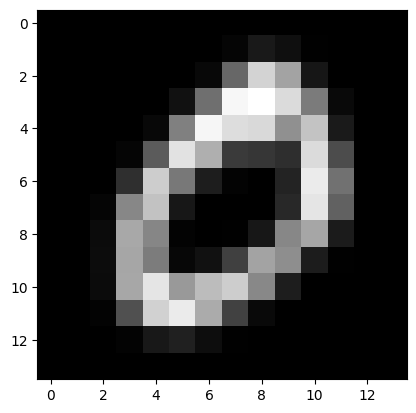

In [ ]:
plt.imshow(data[1], cmap='gray')

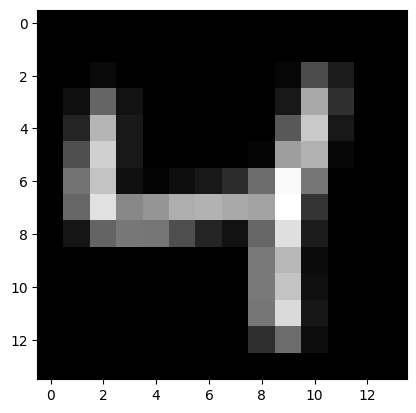

In [ ]:
plt.imshow(data[2], cmap='gray')

In [ ]:
softmax = torch.nn.Softmax()

In [ ]:
def predict(model, data_point):
    pred_probs = softmax(model(data_point))
    return pred_probs

In [ ]:
predict(classical_model, data_patched[0])

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[1.2652e-12, 2.0124e-09, 7.3964e-06, 5.5961e-05, 4.5556e-14, 9.9994e-01,
         2.6938e-08, 6.5773e-09, 1.8020e-08, 3.8048e-12, 2.4654e-17, 1.7068e-19,
         4.0443e-19, 1.8598e-18, 3.9982e-20, 6.5816e-18, 4.4893e-18, 4.0757e-17,
         7.5340e-18, 1.7712e-19, 2.1387e-17, 2.0978e-17, 4.6131e-19, 5.6343e-19,
         1.1312e-18, 7.6295e-20, 1.5700e-19, 1.9105e-17, 6.4196e-20, 2.0688e-19,
         8.1013e-21, 3.5699e-18, 7.2076e-18, 1.7898e-18, 2.4545e-19, 1.0775e-19,
         3.3559e-18, 2.1780e-19, 1.0751e-18, 1.6731e-18, 8.3257e-20, 2.9525e-19,
         8.6948e-19, 7.0081e-18, 5.6436e-20, 5.0650e-20, 5.1879e-20, 3.4183e-19,
         4.7451e-20, 3.8808e-19, 1.0090e-18, 4.4885e-19, 1.1859e-18, 1.2311e-19,
         4.2099e-18, 2.6392e-19, 4.9327e-20, 9.8514e-19, 7.0377e-19, 6.6213e-19,
         1.4561e-18, 5.4185e-18, 5.6345e-18, 7.9082e-18]],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
softmax(classical_model(data_patched[0]))

tensor([[1.2652e-12, 2.0124e-09, 7.3964e-06, 5.5961e-05, 4.5556e-14, 9.9994e-01,
         2.6938e-08, 6.5773e-09, 1.8020e-08, 3.8048e-12, 2.4654e-17, 1.7068e-19,
         4.0443e-19, 1.8598e-18, 3.9982e-20, 6.5816e-18, 4.4893e-18, 4.0757e-17,
         7.5340e-18, 1.7712e-19, 2.1387e-17, 2.0978e-17, 4.6131e-19, 5.6343e-19,
         1.1312e-18, 7.6295e-20, 1.5700e-19, 1.9105e-17, 6.4196e-20, 2.0688e-19,
         8.1013e-21, 3.5699e-18, 7.2076e-18, 1.7898e-18, 2.4545e-19, 1.0775e-19,
         3.3559e-18, 2.1780e-19, 1.0751e-18, 1.6731e-18, 8.3257e-20, 2.9525e-19,
         8.6948e-19, 7.0081e-18, 5.6436e-20, 5.0650e-20, 5.1879e-20, 3.4183e-19,
         4.7451e-20, 3.8808e-19, 1.0090e-18, 4.4885e-19, 1.1859e-18, 1.2311e-19,
         4.2099e-18, 2.6392e-19, 4.9327e-20, 9.8514e-19, 7.0377e-19, 6.6213e-19,
         1.4561e-18, 5.4185e-18, 5.6345e-18, 7.9082e-18]],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
softmax(hybrid2_model(data_patched[0]).squeeze())

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([2.1496e-08, 6.4930e-09, 5.7211e-04, 4.7003e-02, 9.1883e-11, 9.5228e-01,
        4.9268e-07, 2.2134e-05, 1.1561e-04, 2.6288e-06, 3.7580e-15, 2.1563e-15,
        5.3368e-15, 2.6479e-15, 4.8519e-15, 4.4403e-15, 2.7287e-15, 4.7952e-15,
        2.6579e-15, 2.5445e-15, 1.3232e-14, 5.4005e-15, 3.5949e-15, 3.9522e-15,
        3.5903e-15, 4.1827e-15, 8.5116e-15, 2.7939e-15, 1.3901e-14, 1.8877e-15,
        1.1568e-15, 3.1282e-15, 5.7351e-15, 2.8981e-15, 1.2113e-15, 1.9798e-14,
        3.1757e-15, 3.3688e-15, 2.3433e-15, 1.0792e-15, 1.7602e-15, 2.3645e-15,
        1.4387e-15, 1.1732e-15, 3.7432e-15, 8.1319e-15, 3.7794e-15, 2.1177e-15,
        1.8090e-15, 3.4188e-15, 3.5004e-15, 2.8910e-15, 1.1686e-14, 2.9457e-15,
        2.9485e-15, 3.4753e-16, 4.1328e-15, 2.6890e-15, 5.2298e-15, 1.0335e-15,
        5.0550e-15, 1.7627e-15, 2.0097e-15, 6.8397e-15],
       grad_fn=<SoftmaxBackward0>)